# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. 

Построим модель с максимально большим значением `accuracy`.

## Откроем и изучим файл

### Импортируем библиотеки и методы

Но сначала - спасибо [стаковерфлоу](https://ru.stackoverflow.com/questions/986879/%D0%9A%D0%B0%D0%BA%D0%BE%D0%B9-%D0%BA%D0%BE%D0%BC%D0%B0%D0%BD%D0%B4%D0%BE%D0%B9-%D1%83%D0%B1%D1%80%D0%B0%D1%82%D1%8C-%D0%BF%D1%80%D0%B5%D0%B4%D1%83%D0%BF%D1%80%D0%B5%D0%B6%D0%B4%D0%B5%D0%BD%D0%B8%D1%8F-python-jupyter-notebook) за счастливое детство.

In [1]:
import warnings

warnings.filterwarnings('ignore')

Зададим значения глобальных переменных

In [2]:
# импортируем библиотеки и методы
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [3]:
#Отключим предупреждения python
import warnings
warnings.filterwarnings('ignore')

In [4]:
# зафиксируем "random_state"
RANDOM_STATE = 5553535

### Прочитаем данные

In [5]:
# откроем датасет либо локально, либо из интернета
try:
    df = pd.read_csv('/datasets/users_behavior.csv', sep=',')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv', sep=',')

Познакомимся с данными:

In [6]:
display(df.head(5))
display(df.describe())
df.info()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [7]:
# для очищения совести проверим датасет на явные дубликаты
df.duplicated().sum()

0

Дубликатов нет, и можно заметить что порядка 30% датасета - пользователи тарифа `Ультра`.

### Рассмотрим плотность значений

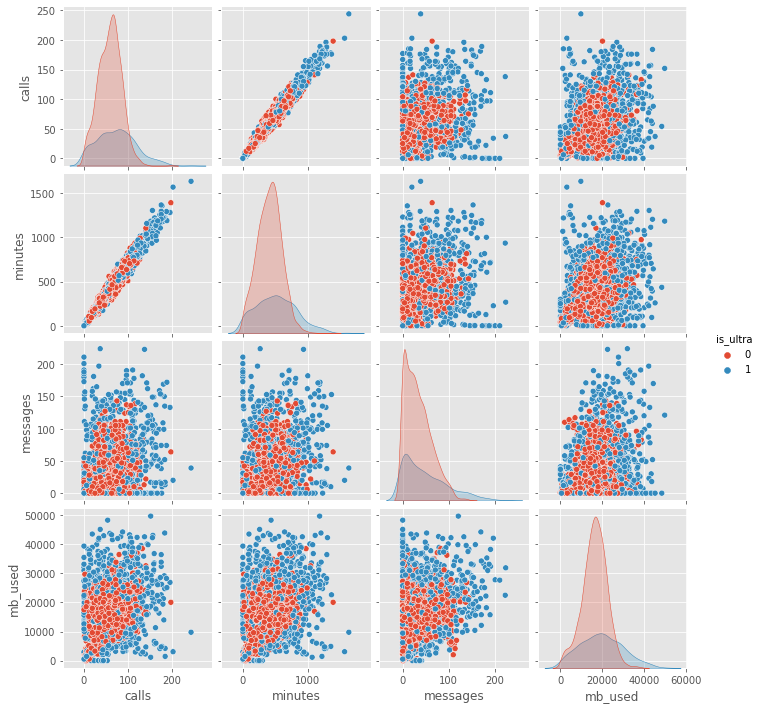

In [8]:
plt.style.use('ggplot')
sns.pairplot(df, hue='is_ultra')
plt.show()

Количество сообщений, количество звонков и длительность разговоров максимально близка для пользователей тарифа `Смарт`. Также стоит отметить корреляцию длительности и количества звонков.

### Проверим данные на мультиколлинеарность

Построим тепловую карту:

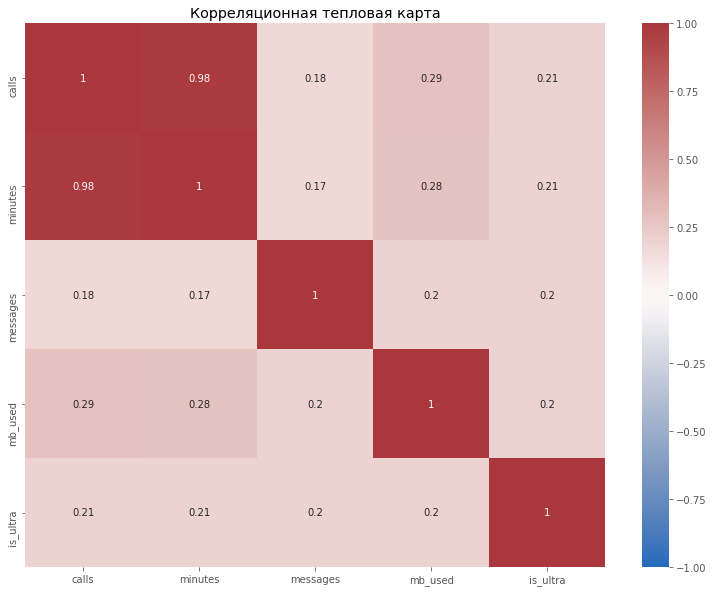

In [9]:
fig, ax = plt.subplots(figsize=(13,10))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')
heatmap.set_title('Корреляционная тепловая карта')
plt.show()

Количество звонков и длительность звонков - мультиколлинеарные признаки, значит нужно оставить один.

Столбец `calls` пойдет под нож, так как `minutes` более предпочтительный признак для модели.

In [10]:
df = df.drop('calls', axis=1)

### Выводы

Датасет предобработан, дубликатов нет, пропусков тоже. Получили общее представление о данных, избавились от мультиколлинеарности, теперь можно выделить признаки и разбить данные на выборки.

## Разбиваем данные на выборки

### Выделим признаки для модели

In [11]:
# выделим признаки
features = df.drop('is_ultra', axis=1)

# выделим целевой признак
target = df['is_ultra']

### Разделим данные на выборки

50% от датасета выделим под обучающую выборку, по четверти - валидационной и тестовой выборкам, но сначала зафиксируем `random_state`.

In [12]:
# отделим обучающую выборку
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=RANDOM_STATE, stratify=target)

# разделим на тестовый и валидационный
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.5, random_state=RANDOM_STATE, stratify=target_test)

Проверим корректность разбивки данных:

In [13]:
print('Cоотношения:',
      f'{len(features_train) / len(features):.2f} обучающей к '
      f'{len(features_valid) / len(features):.2f} тестовой, и к '
      f'{len(features_test) / len(features):.2f} валидационной')

Cоотношения: 0.60 обучающей к 0.20 тестовой, и к 0.20 валидационной


В результате получили три набора данных: обучающий,валидационный и тестовый.

Теперь можно приступить к обучению.

## Исследуем модели

Но сначала создадим счетчик лучшей модели:

In [14]:
# лучшая модель
best_model = None
best_result = 0

### Модель решающего дерева

In [15]:
# лучший результат
DecisionTree_result = 0
# глубина дерева
DecisionTree_depth = 0

# найдем оптимальные значения гиперпараметров в цикле
for depth in range(1, 50):
    #модель решающего дерева
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
    model.fit(features_train, target_train)
    
    # посчитаем качество модели на валидационной выборке
    result = model.score(features_valid, target_valid)
    
    # сравним результаты
    if result > DecisionTree_result:
        DecisionTree_result = result
        DecisionTree_depth = depth
    
if DecisionTree_result > best_result:
    best_result = DecisionTree_result
    best_model = model

        
print('Точность предсказания на обучающей выборке:', f'{DecisionTree_result:.2f}')
print('Оптимальное значение глубины дерева:', DecisionTree_depth)

Точность предсказания на обучающей выборке: 0.79
Оптимальное значение глубины дерева: 7


Точность предсказания 79%, что удовлетворяет условию задания.

Посмотрим на другие модели и проверим, смогут ли они составить конкуренцию решающему дереву.

### Модель логистической регрессии

In [16]:
# лучший результат
LogisticRegression_result = 0

# лучший алгоритм оптимизации
solver = ['sag', 'saga', 'newton-cg', 'lbfgs', 'liblinear']
best_solver = []

for i in range(len(solver)):
    # модель логистической регрессии
    model = LogisticRegression(random_state=RANDOM_STATE, solver=solver[i], max_iter=500)
    model.fit(features_train, target_train)

    # посчитаем качество модели на валидационной выборке
    result = model.score(features_valid, target_valid)
    
    # сравним результаты
    if result > LogisticRegression_result:
        LogisticRegression_result = result
        best_solver = solver[i]
                
# сохраним в лучшую модель    
if LogisticRegression_result > best_result:
    best_result = LogisticRegression_result
    best_model = model
    
print('Точность предсказания на обучающей выборке:',f'{LogisticRegression_result:.2f}')
print('Лучший алгоритм оптимизации:', best_solver)

Точность предсказания на обучающей выборке: 0.76
Лучший алгоритм оптимизации: newton-cg


Точность предсказаний ниже, чем у модели решающего дерева, но все ровно удовлетворяет поставленному условию `accuracy` > 0.75.

### Модель случайного леса

In [17]:
# лучший результат
RandomForest_result = 0
# глубина дерева
RandomForest_depth = 0
# количество деревьев
RandomForest_est = 0

# найдем оптимальные значения гиперпараметров в цикле
for est in range(5, 100, 5):
    for depth in range(1, 20):
        # модель леса
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        
        # посчитаем качество модели на валидационной выборке
        result = model.score(features_valid, target_valid)
        
        # сравним результаты
        if result > RandomForest_result:
            RandomForest_result = result
            RandomForest_depth = depth
            RandomForest_est = est
        
# сохраним в лучшую модель    
if RandomForest_result > best_result:
    best_result = RandomForest_result
    best_model = model

print('Точность предсказания на обучающей выборке:' f'{RandomForest_result:.4f}')
print('Оптимальная глубина дерева:', RandomForest_depth)
print('Оптимальное количество деревьев:', RandomForest_est)

Точность предсказания на обучающей выборке:0.8103
Оптимальная глубина дерева: 7
Оптимальное количество деревьев: 45


Точность предсказаний лучшая среди всех моделей на текущий момент - 0.81.

### Модель градиентного бустинга

In [18]:
# лучший результат
GradientBoosting_result = 0
# количество итераций
GradientBoosting_est = 0

# найдем оптимальные значения гиперпараметров в цикле
for est in range(1, 101):
    # модель градиентного бустинга
    model = GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=est)
    model.fit(features_train, target_train)
    
    # посчитаем качество модели на валидационной выборке
    result = model.score(features_valid, target_valid)
    
    # сравним результаты
    if result > GradientBoosting_result:
        GradientBoosting_result = result
        GradientBoosting_est = est
        
# сохраним в лучшую модель    
if GradientBoosting_result > best_result:
    best_result = GradientBoosting_result
    model = best_model
        
print('Точность предсказания на обучающей выборке:' f'{GradientBoosting_result:.2f}')
print('Оптимальное количество итераций:', GradientBoosting_est)

Точность предсказания на обучающей выборке:0.81
Оптимальное количество итераций: 51


Результат до второго знака такой же, как и у случайного леса, и также удовлетваряет условию `accuracy` > 0.75. 

Посмотрим на финальный результат:

In [19]:
print('Лучшая точность предсказания на обучающей выборке у', best_model,
      'с результатом:', f'{best_result:.4f}')

Лучшая точность предсказания на обучающей выборке у RandomForestClassifier(max_depth=19, n_estimators=95, random_state=5553535) с результатом: 0.8103


### Выводы

В результате проведённых исследований, мы получили лучшую точность предсказания на обучающей выборке у случайного леса с результатом **0.8103**. 

Теперь можно опробовать получившуюся модель на тестовой выборке и проверить её на переобучение.

## Проверим модель на тестовой выборке

Получим предсказания на тестовой выборке, рассчитаем метрики качества модели.

In [20]:
# предсказания модели
predictions = best_model.predict(features_test)

# посчитаем качество модели
accuracy = accuracy_score(target_test, predictions)
precision = precision_score(target_test, predictions)
recall = recall_score(target_test, predictions)

print('Доля правильных ответов на тестовой выборке:' f'{accuracy:.4f}')
print('Доля ожидаемых положительных событий на тестовой выборке:' f'{precision:.2f}')
print('Чувствительность на тестовой выборке:' f'{recall:.2f}')

Доля правильных ответов на тестовой выборке:0.8180
Доля ожидаемых положительных событий на тестовой выборке:0.76
Чувствительность на тестовой выборке:0.59


`accuracy` на тестовой и валидационной выборках приблизительно равны, значит модель не переобучена.

## (бонус) Проверим модели на адекватность

Создадим проверочную основную (baseline) модель с помощью Dummy-классификатора.

In [22]:
# baseline модель dummy-классификатора
dummy = DummyClassifier(random_state=RANDOM_STATE)
dummy.fit(features_train, target_train)
dummy_prediction = dummy.predict(features_test)
dummy_accuracy= accuracy_score(target_test, dummy_prediction)

# выведем результаты моделирования
print('Точность предсказаний Dummy-классификатора на тестовой выборке:',f'{dummy_accuracy:.2f}')

Точность предсказаний Dummy-классификатора на тестовой выборке: 0.69


Точность предсказаний у случайного леса - 0.81, а у проверочной модели - 0.69 *(nice)*.

Случайный лес прошел проверку на адекватность.

## Общий вывод исследования модели для задачи классификации

В результате проведённой работы были проверены следующие модели:

1. Дерево решений
2. Логистическая регрессия
3. Случайный лес
4. Градиентный бустинг

Для всех моделей были найдены оптимальные значения гиперпараметров для получения наиболее точных предсказаний.

Лучшая точность предсказания на обучающей выборке у **случайного леса** с результатом **0.8103**, проверка на тестовой выборке дала результат **0.8149**.

Незначительное расхождение этих результатов свидетельствует о том, что **модель не переобучена**.

Дополнительно модель **прошла проверку на адекватность**. По сравнению с baseline моделью dummy-классификатора точность предсказаний у случайного леса значительно выше - 0.81 против - 0.69.